In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from matplotlib.ticker import FormatStrFormatter


## Import ASHRAE Thermal Comfort Database 2

In [10]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

/tmp/ipykernel_4349/4215538025.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


In [11]:
# Merge building metadata and measurement data
df_data = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_data.building_id.unique()))
print('Total records:', len(df_data))

Total buildings: 809
Total records: 109033


### Data cleaning

In [12]:
# Merge two outdoor air temperature columns as a new column
df_data.loc[:, 't_out_combined'] = df_data.loc[:, 't_out_isd'].fillna(df_data.loc[:, 't_out'])
# Remove the two outdoor air temperature columns
df_data = df_data.drop(columns=['t_out_isd', 't_out'])

# Keep rows that simultaneously have data for all variables in cols 
def keep_rows(df, cols):
    df_new = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_new['building_id'].unique()), cols)
    print(f'Qualified records:', len(df_new))
    return df_new

In [13]:
cols = ['t_out_combined', 'top', 'thermal_sensation']
df_data = keep_rows(df_data, cols).copy()

Qualified buildings: 553 ['t_out_combined', 'top', 'thermal_sensation']
Qualified records: 38467


## Netural temeprature estimation

In [14]:
# neutral temepratuer calculation example
df_data_1bldg = df_data[df_data['building_id'] == 1]
df_data_1bldg.head()

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,8.4,0.40,8.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,5.1,-0.07,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,7.0,0.14,5.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,5.0,-0.06,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833


### linear regression method (a)

/tmp/ipykernel_4349/2967112302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])


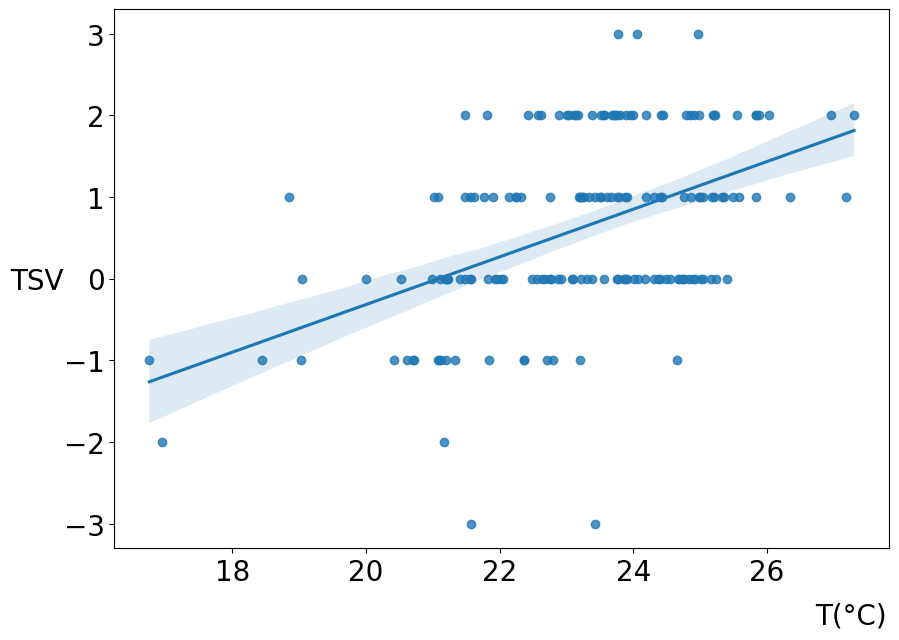

Neutral temperature is 21.1 degree Celsius.
80 percent acceptable temperature range is (18.2 ~ 24.0) degree Celsius.
90 percent acceptable temperature range is (19.4 ~ 22.8) degree Celsius.
                            OLS Regression Results                            
Dep. Variable:      thermal_sensation   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     47.03
Date:                Fri, 08 Sep 2023   Prob (F-statistic):           1.30e-10
Time:                        03:03:19   Log-Likelihood:                -237.80
No. Observations:                 169   AIC:                             479.6
Df Residuals:                     167   BIC:                             485.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coe

In [15]:
# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='thermal_sensation ~ top', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])
# plot the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_1bldg)
plt.xlabel('T(°C)', fontsize=20)
plt.ylabel('TSV', rotation=0, fontsize=20)
# plt.title('Regress thermal sensation votes on indoor temperature')

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(0.95, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.47)

plt.xticks(fontsize=20)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=20)  # Set font size for y-axis tick labels

plt.grid(False)
plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['top'] < 0.05:
    a = lm_result.params['top']
    b = lm_result.params['Intercept']
    neutral_temp = -b / a
    temp80_up = (0.85-b)/a
    temp80_low = (-0.85-b)/a
    temp90_up = (0.5-b)/a
    temp90_low = (-0.5-b)/a
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))
else:
    print('The slope is not significant.')

# statistical anayalsis summary
print(lm_result.summary())

### linear regression method (b)

/tmp/ipykernel_4349/636551615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])


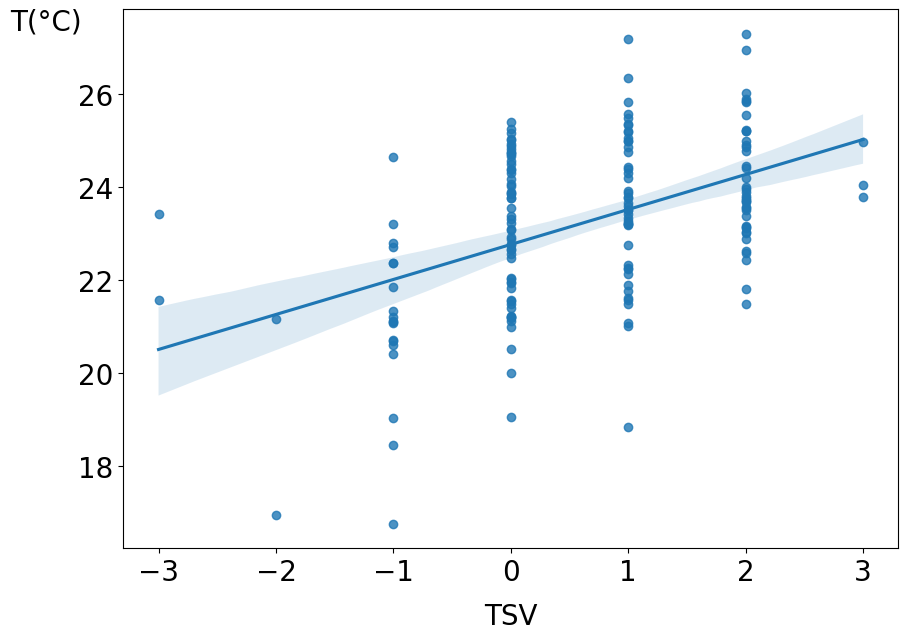

Neutral temperature is 22.8 degree Celsius.
80 percent acceptable temperature range is (22.1 ~ 23.4) degree Celsius.
90 percent acceptable temperature range is (22.4 ~ 23.1) degree Celsius.
                            OLS Regression Results                            
Dep. Variable:                    top   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     47.03
Date:                Fri, 08 Sep 2023   Prob (F-statistic):           1.30e-10
Time:                        03:03:20   Log-Likelihood:                -317.89
No. Observations:                 169   AIC:                             639.8
Df Residuals:                     167   BIC:                             646.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    

In [16]:
# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='top ~ thermal_sensation', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])
# plot the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='top', data=df_data_1bldg)
plt.xlabel('TSV', fontsize=20)
plt.ylabel('T(°C)', rotation=0, fontsize=20)
# plt.title('Regress thermal sensation votes on indoor temperature')

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.95)

plt.xticks(fontsize=20)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=20)  # Set font size for y-axis tick labels

plt.grid(False)
plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['thermal_sensation'] < 0.05:
    a = lm_result.params['thermal_sensation']
    b = lm_result.params['Intercept']
    neutral_temp = b
    temp80_up = 0.85*a + b
    temp80_low = (-0.85)*a + b
    temp90_up = 0.5*a + b
    temp90_low = (-0.5)*a + b
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))

else:
    print('The slope is not significant.')

# statistical anayalsis summary
print(lm_result.summary())

## Adaptive Comfort Model

### Two linear regression functions

In [25]:
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = lm_result.params['top']
            b = lm_result.params['Intercept']
            n_t = -b / a
            t_80_up = (0.85-b)/a
            t_80_low = (-0.85-b)/a
            t_90_up = (0.5-b)/a
            t_90_low = (-0.5-b)/a
            return [n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            a = lm_result.params['thermal_sensation']
            b = lm_result.params['Intercept']
            n_t = b
            t_80_up = 0.85*a + b
            t_80_low = (-0.85)*a + b
            t_90_up = 0.5*a + b
            t_90_low = (-0.5)*a + b
            return [n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

### Neutral temeprature estimation for all buildings

In [49]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'top', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'database']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,database
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,1.0
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,1.0
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,1.0
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,1.0
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,1.0


In [50]:
# calculate all temperature values for each building
columns_name = ['n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,database,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_90_low_a,t_90_low_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,1.0,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419,22.803727,23.143891,19.376941,22.390948
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,1.0,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834,23.093912,22.465728,21.678544,22.148029
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,1.0,NaN,23.174896,NaN,23.186122,NaN,23.163670,NaN,23.181500,NaN,23.168292
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,1.0,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182,24.759080,24.169948,22.777103,23.674566
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,1.0,NaN,22.104007,NaN,22.220827,NaN,21.987187,NaN,22.172725,NaN,22.035290


In [53]:
# get rid of all nan values in the n_t_a column
df_bldg_sig_a = df_bldg[~df_bldg['n_t_a'].isna()]
print('regressing thermal sensation against operative temperature')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_a))

df_bldg_nv_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_a))

regressing thermal sensation against operative temperature
number of buildings that have statistical significant neutral temperature: 215
number of naturally ventilated buildings that have statistical significant neutral temperature: 73


In [54]:
# get rid of all nan values in the n_t_b column
df_bldg_sig_b = df_bldg[~df_bldg['n_t_b'].isna()]
print('regressing operative temperature against thermal sensation')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_b))

df_bldg_nv_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_b))


regressing operative temperature against thermal sensation
number of buildings that have statistical significant neutral temperature: 491
number of naturally ventilated buildings that have statistical significant neutral temperature: 180


### Weighted regression function

In [55]:
df_bldg

,building_id,ta,top,t_out_combined,records,cooling_type,database,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_90_low_a,t_90_low_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,1.0,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419,22.803727,23.143891,19.376941,22.390948
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,1.0,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834,23.093912,22.465728,21.678544,22.148029
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,1.0,NaN,23.174896,NaN,23.186122,NaN,23.163670,NaN,23.181500,NaN,23.168292
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,1.0,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182,24.759080,24.169948,22.777103,23.674566
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,1.0,NaN,22.104007,NaN,22.220827,NaN,21.987187,NaN,22.172725,NaN,22.035290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,737,24.316162,25.010101,28.469928,99,Air Conditioned,2.1,NaN,25.215968,NaN,25.453278,NaN,24.978657,NaN,25.355562,NaN,25.076373
549,738,24.202332,24.372798,28.905322,387,Air Conditioned,2.1,31.830522,24.452358,38.821606,24.526939,24.839438,24.377776,35.942925,24.496229,27.718120,24.408486
550,739,22.957143,23.000000,25.815476,56,Air Conditioned,2.1,NaN,23.568421,NaN,23.850263,NaN,23.286579,NaN,23.734211,NaN,23.402632
551,780,22.707017,23.022001,10.063022,2242,Naturally Ventilated,2.0,20.161369,22.809739,23.815291,23.080864,16.507447,22.538615,22.310735,22.969224,18.012003,22.650255


In [56]:
def weighted_regression(x, y, weights, **kwargs):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    print(model.params)
    plt.plot(x, intercept + slope * x, **kwargs)

const             18.055497
t_out_combined     0.286744
dtype: float64


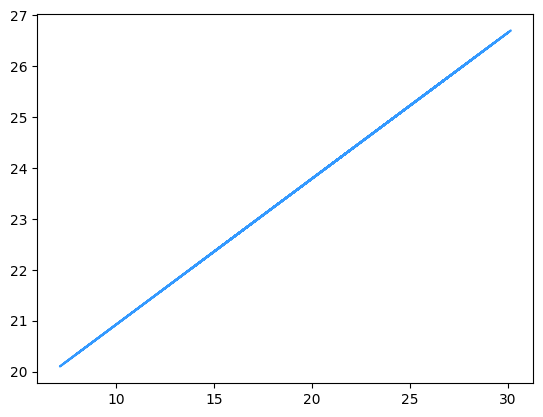

In [57]:
weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['n_t_a'], df_bldg_nv_a['records'], color="#3399FF")

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='t_out_combined', ylabel='n_t_a'>

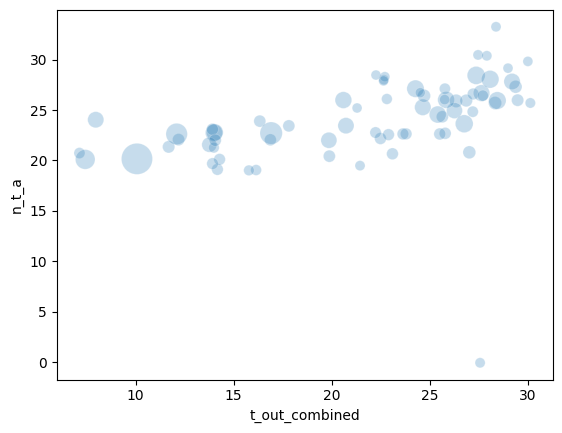

In [58]:
sns.scatterplot(data=df_bldg_nv_a, x='t_out_combined', y='n_t_a', size='records', sizes=(50, 500), legend=False, alpha=0.25)

In [61]:
df_bldg_nv_a

,building_id,ta,top,t_out_combined,records,cooling_type,database,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_90_low_a,t_90_low_b
60,61,28.054140,28.029344,26.871975,157,Naturally Ventilated,1.0,25.935314,27.497406,28.190748,28.070345,23.679880,26.924467,27.262040,27.834429,24.608588,27.160383
61,62,28.288618,28.276772,25.653252,124,Naturally Ventilated,1.0,24.332890,27.640963,27.605373,28.168533,21.060406,27.113392,26.257880,27.951298,22.407899,27.330627
62,63,28.614493,28.618457,25.782609,69,Naturally Ventilated,1.0,27.108738,28.100250,28.420516,28.550514,25.796959,27.649985,27.880372,28.365111,26.337103,27.835388
63,64,27.770142,27.692614,26.355213,211,Naturally Ventilated,1.0,25.900533,27.419813,27.797875,27.708637,24.003192,27.130988,27.016616,27.589709,24.784450,27.249916
64,65,26.114286,26.130612,22.820408,49,Naturally Ventilated,1.0,26.090105,26.120120,25.097683,25.863051,27.082528,26.377188,25.506327,25.968903,26.673883,26.271336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,590,18.417949,18.582051,15.778499,39,Naturally Ventilated,2.0,19.021124,18.642105,33.576371,20.632895,4.465876,16.651316,27.583034,19.813158,10.459213,17.471053
533,623,24.190335,24.123471,16.913373,1042,Naturally Ventilated,2.0,22.708189,23.792413,25.499566,24.445363,19.916813,23.139463,24.350176,24.176501,21.066203,23.408325
534,624,22.759326,22.866629,12.089942,938,Naturally Ventilated,2.0,22.620243,22.844636,27.166365,23.250435,18.074121,22.438837,25.294433,23.083341,19.946054,22.605931
551,780,22.707017,23.022001,10.063022,2242,Naturally Ventilated,2.0,20.161369,22.809739,23.815291,23.080864,16.507447,22.538615,22.310735,22.969224,18.012003,22.650255


/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

<Axes: xlabel='t_out_combined', ylabel='y_values'>

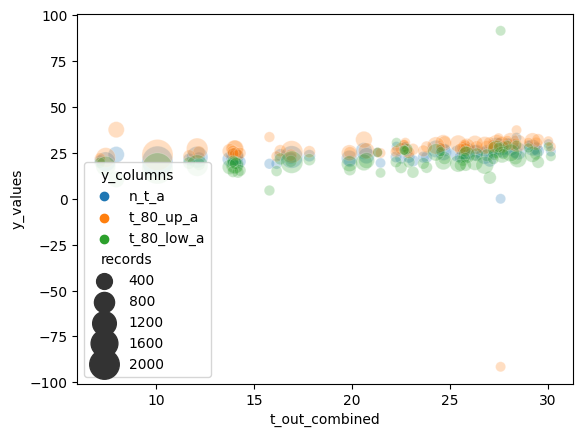

In [65]:
y_columns = ['n_t_a', 't_80_up_a', 't_80_low_a']
melted_df = pd.melt(df_bldg_nv_a, id_vars=['t_out_combined', 'records'], value_vars=y_columns, var_name='y_columns', value_name='y_values')
sns.scatterplot(data=melted_df, x='t_out_combined', y='y_values', hue='y_columns', size='records', sizes=(50, 500), alpha=0.25)
# fit linear regression lines for each y_columns

In [59]:
df_bldg.columns

Index(['building_id', 'ta', 'top', 't_out_combined', 'records', 'cooling_type',
       'database', 'n_t_a', 'n_t_b', 't_80_up_a', 't_80_up_b', 't_80_low_a',
       't_80_low_b', 't_90_up_a', 't_90_up_b', 't_90_low_a', 't_90_low_b'],
      dtype='object')

In [24]:
# eliminate outliers
df_bldg_acm_a = df_bldg[(df_bldg['t_out_combined'] >= 10) & (df_bldg['t_out_combined'] <= 33) &
                        (df_bldg['n_t_a'] > 17) & (df_bldg['n_t_a'] < 32)].copy()

NameError: name 'df_models' is not defined